In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from torch.cuda.amp import GradScaler
from torch.amp import autocast 
from IPython.display import clear_output
import json
from datetime import datetime
from transformers import get_constant_schedule_with_warmup
from collections import defaultdict
from torch.utils.data import Sampler
import random
import itertools

In [2]:
torch.cuda.mem_get_info()

(20773273600, 20937965568)

In [3]:
torch.cuda.empty_cache()

In [4]:
MODEL_NAME = 'BAAI/bge-m3'  # 8k, мультиязычный
MAX_DESC_LENGTH = 8192
MAX_LYRICS_LENGTH = 8192
BATCH_SIZE = 2            # 8k сильно бьёт по VRAM
GRADIENT_ACCUMULATION_STEPS = 128  # чтобы сохранить эффективный размер батча
PROJECTION_DIM = 2048
EPOCHS = 25
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01
PATIENCE = 3
DROP = 0.3

# Paths
CHECKPOINT_DIR = '25_ep_tag_hard_negs_bge_8192'
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'bi_encoder_checkpoint.pth')
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, 'bi_encoder_best.pth')
VAL_LOSSES_PATH = os.path.join(CHECKPOINT_DIR, 'val_losses.json')

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [5]:
# Load datasets
interpretation_ds = load_dataset("jamimulgrave/Song-Interpretation-Dataset")['train']
enrich_ds = load_dataset("seungheondoh/enrich-music4all")['train']

print(f"Interpretation dataset size: {len(interpretation_ds)}")
print(f"Enrich dataset size: {len(enrich_ds)}")

Generating train split:   0%|          | 0/310315 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/86410 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/21953 [00:00<?, ? examples/s]

Interpretation dataset size: 310315
Enrich dataset size: 86410


In [6]:
# Create mappings
pseudo_map = {row['track_id']: row['pseudo_caption'] for row in enrich_ds}
artist_map = {row['track_id']: row['artist_name'] for row in enrich_ds}
tag_map = {row['track_id']: row.get('tag_list', []) for row in enrich_ds}

print(f"Mappings created: {len(pseudo_map), len(artist_map), len(tag_map)} tracks")

Mappings created: (86410, 86410, 86410) tracks


In [7]:
artist_track_map = defaultdict(list)

for track_id, artist in artist_map.items():
    artist_track_map[artist].append(track_id)

In [8]:
# Extract data
rng = np.random.default_rng(42)

music4all_ids = interpretation_ds['music4all_id']
descriptions = interpretation_ds['comment']
lyrics_list = interpretation_ds['lyrics']
num_samples = len(music4all_ids)

perm = rng.permutation(len(music4all_ids))
music4all_ids = [music4all_ids[i] for i in perm]
descriptions = [descriptions[i] for i in perm]
lyrics_list  = [lyrics_list[i]  for i in perm]

print(f"Total samples: {num_samples}")

Total samples: 310315


In [9]:
# Train/Val/Test split
train_idx = int(0.8 * num_samples)
val_idx = int(0.9 * num_samples)

train_ids = music4all_ids[:train_idx]
train_descs = descriptions[:train_idx]
train_lyrics = lyrics_list[:train_idx]

val_ids = music4all_ids[train_idx:val_idx]
val_descs = descriptions[train_idx:val_idx]
val_lyrics = lyrics_list[train_idx:val_idx]

test_ids = music4all_ids[val_idx:]
test_descs = descriptions[val_idx:]
test_lyrics = lyrics_list[val_idx:]

print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

Train: 248252, Val: 31031, Test: 31032


In [10]:
# Build train-specific mappings for sampler
train_index_to_track = {i: train_ids[i] for i in range(len(train_ids))}
train_index_to_artist = {i: artist_map.get(track_id, 'unknown') for i, track_id in train_index_to_track.items()}
train_artist_to_indices = defaultdict(list)
for i, artist in train_index_to_artist.items():
    if artist != 'unknown':
        train_artist_to_indices[artist].append(i)


train_index_to_tags  = {i: set(tag_map.get(train_index_to_track[i], []))
                        for i in range(len(train_ids))}

# 2) Инвертированный индекс: тег -> индексы
tag_to_indices = defaultdict(list)
for i, tags in train_index_to_tags.items():
    for t in tags:
        tag_to_indices[t].append(i)

In [11]:
class TextPairDataset(Dataset):
    def __init__(self, descriptions, lyrics):
        self.descriptions = descriptions
        self.lyrics = lyrics
    def __len__(self): 
        return len(self.descriptions)
    def __getitem__(self, i):
        return {
            'desc': self.descriptions[i],
            'lyrics': self.lyrics[i]
        }

def collate_fn(batch):
    desc_texts   = [b['desc'] for b in batch]
    lyrics_texts = [b['lyrics'] for b in batch]
    desc_enc = tokenizer(
        desc_texts, truncation=True, padding=True,
        max_length=MAX_DESC_LENGTH, return_tensors='pt'
    )
    lyr_enc = tokenizer(
        lyrics_texts, truncation=True, padding=True,
        max_length=MAX_LYRICS_LENGTH, return_tensors='pt'
    )
    return {
        'desc_input_ids': desc_enc['input_ids'],
        'desc_attention_mask': desc_enc['attention_mask'],
        'lyrics_input_ids': lyr_enc['input_ids'],
        'lyrics_attention_mask': lyr_enc['attention_mask'],
    }

In [12]:
def build_tag_hard_negatives(train_index_to_tags, tag_to_indices, n=4, 
                                         max_combinations_per_level=20000, 
                                         shuffle_within_level=True):
    """
    Для каждого pos_idx подбирает до n hard‑негативов:
    - сначала с максимальным пересечением по всем тегам,
    - если не набралось n, то по (m-1) тегам, потом (m-2), ..., до 1.
    Аргументы:
      train_index_to_tags: {idx: set(tags)}
      tag_to_indices: {tag: [idx, ...]}
      n: целевое число негативов на позитив
      max_combinations_per_level: ограничение числа перебираемых комбинаций на уровне,
        чтобы не взорваться на треках с большим числом тегов
      shuffle_within_level: перемешивать кандидатов на уровне для случайного тай-брейка
    Возвращает:
      tag_hards: {idx: [neg_idx1, neg_idx2, ...]} длиной <= n
    """
    tag_hards = defaultdict(list)
    indices = list(train_index_to_tags.keys())

    for pos_idx in tqdm(indices, desc="Building tag negatives"):
        tags_set = train_index_to_tags[pos_idx]
        if not tags_set:
            tag_hards[pos_idx] = []
            continue
        tags = list(tags_set)
        m = len(tags)
        picked = []
        picked_set = set()

        # ускорение: заранее соберём множества индексов по каждому тегу
        tag_to_set = {}
        for t in tags:
            tag_to_set[t] = set(tag_to_indices.get(t, []))

        # уровень k = m, m-1, ..., 1
        for k in range(m, 0, -1):
            if len(picked) >= n:
                break

            # перебираем комбинации тегов размера k
            # потенциально их много, поэтому вводим ограничение
            comb_iter = itertools.combinations(tags, k)
            # ограничим количество обработанных комбинаций
            processed = 0

            level_candidates = set()
            for comb in comb_iter:
                if processed >= max_combinations_per_level:
                    break
                processed += 1

                # пересечение индексов по выбранным k тегам
                s = None
                for t in comb:
                    if s is None:
                        s = set(tag_to_set[t])
                    else:
                        s &= tag_to_set[t]
                    if not s:
                        break
                if not s:
                    continue

                # исключаем сам трек
                s.discard(pos_idx)
                # добавляем к уровневым кандидатам
                level_candidates |= s

                # если уже достаточно на уровне, можно не перебирать оставшиеся комбинации
                if len(level_candidates) + len(picked) >= n:
                    # не обязательно break — оставим ещё немного кандидатов для тай-брейка
                    pass

            if not level_candidates:
                continue

            # убираем уже выбранных и берем недостающее количество
            level_list = [j for j in level_candidates if j not in picked_set]
            if not level_list:
                continue
            if shuffle_within_level:
                random.shuffle(level_list)  # случайный тай-брейк внутри фиксированного k
            need = n - len(picked)
            picked_here = level_list[:need]
            picked.extend(picked_here)
            picked_set.update(picked_here)

        tag_hards[pos_idx] = picked
    return tag_hards


In [13]:
tag_hards = build_tag_hard_negatives(train_index_to_tags, tag_to_indices)

Building tag negatives: 100%|██████████| 248252/248252 [21:21<00:00, 193.79it/s]


In [14]:
len(tag_hards)

248252

In [15]:
class TagHardNegativeSampler(Sampler):
    def __init__(self, num_samples, batch_size, tag_hards,
                 index_to_artist=None, artist_to_indices=None,
                 num_tag_hard_per_pos=6, num_artist_hard_per_pos=2,
                 replacement=False):
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.tag_hards = tag_hards
        self.index_to_artist = index_to_artist or {}
        self.artist_to_indices = artist_to_indices or {}
        self.num_tag_hard_per_pos = num_tag_hard_per_pos
        self.num_artist_hard_per_pos = num_artist_hard_per_pos
        self.replacement = replacement
        self.indices = list(range(num_samples))

    def __iter__(self):
        base = self.indices[:]
        random.shuffle(base)
        epoch_indices = []

        for start in range(0, self.num_samples, self.batch_size):
            virtual = []
            num_pos = min(self.batch_size, self.num_samples - start)
            for j in range(num_pos):
                if start + j >= len(base):
                    break
                pos = base[start + j]
                used = set([pos])
                virtual.append(pos)

                # 1) Теговые харды
                tag_list = self.tag_hards.get(pos, [])
                if tag_list:
                    k = min(self.num_tag_hard_per_pos, len(tag_list))
                    if k > 0:
                        if self.replacement:
                            choices = random.choices(tag_list, k=k)
                        else:
                            choices = random.sample(tag_list, k)
                        for c in choices:
                            if c not in used:
                                virtual.append(c); used.add(c)

                # 2) Артист‑харды (fallback/добавка)
                if self.artist_to_indices and self.index_to_artist:
                    artist = self.index_to_artist.get(pos, 'unknown')
                    group = self.artist_to_indices.get(artist, [])
                    avail = [ix for ix in group if ix != pos]
                    k2 = min(self.num_artist_hard_per_pos, len(avail))
                    if k2 > 0:
                        if self.replacement:
                            choices = random.choices(avail, k=k2)
                        else:
                            choices = random.sample(avail, k2)
                        for c in choices:
                            if c not in used:
                                virtual.append(c); used.add(c)

            # 3) Добиваем рандомом до batch_size без повторов
            while len(virtual) < self.batch_size:
                r = random.choice(self.indices)
                if r not in virtual:
                    virtual.append(r)

            virtual = virtual[:self.batch_size]
            random.shuffle(virtual)
            epoch_indices.extend(virtual)

        for idx in epoch_indices[:self.num_samples]:
            yield idx

    def __len__(self):
        return self.num_samples

In [47]:
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Tokenizer loaded: {MODEL_NAME}")

# Datasets and loaders
train_dataset = TextPairDataset(train_descs, train_lyrics)
train_sampler = TagHardNegativeSampler(
    num_samples=len(train_dataset),
    batch_size=BATCH_SIZE,
    tag_hards=tag_hards,
    index_to_artist=train_index_to_artist,
    artist_to_indices=train_artist_to_indices,
    num_tag_hard_per_pos=6,
    num_artist_hard_per_pos=2,
    replacement=False
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=8,
    persistent_workers=True,
    collate_fn=collate_fn
)

val_dataset = TextPairDataset(val_descs, val_lyrics)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, persistent_workers=True, collate_fn=collate_fn)

test_dataset = TextPairDataset(test_descs, test_lyrics)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, persistent_workers=True, collate_fn=collate_fn)


print(f"✓ Train loader with hard negs: {len(train_loader)} batches")
print(f"✓ Val loader: {len(val_loader)} batches")
print(f"✓ Test loader: {len(test_loader)} batches")

Loading tokenizer...
✓ Tokenizer loaded: BAAI/bge-m3
✓ Train loader with hard negs: 124126 batches
✓ Val loader: 15516 batches
✓ Test loader: 15516 batches


In [17]:
class BiEncoder(nn.Module):
    def __init__(self, backbone, projection_dim, p_drop):
        super().__init__()
        self.backbone = backbone
        emb_dim = self.backbone.config.hidden_size
        def head():
            return nn.Sequential(
                nn.Linear(emb_dim, projection_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(p_drop),
                nn.Linear(projection_dim, projection_dim),
                nn.Dropout(p_drop),
            )
        self.desc_head = head()
        self.lyr_head  = head()

    def _mean_pool(self, outputs, attention_mask):
        with autocast('cuda', enabled=False):
            hs = outputs.last_hidden_state.float()
            mask = attention_mask.unsqueeze(-1).float()
            denom = mask.sum(1).clamp_min(1e-6)
            pooled = (hs * mask).sum(1) / denom
        return pooled  # float32

    def encode_description(self, ids, mask):
        out = self.backbone(input_ids=ids, attention_mask=mask)
        proj = self.desc_head(self._mean_pool(out, mask))
        return F.normalize(proj, p=2, dim=1)

    def encode_lyrics(self, ids, mask):
        out = self.backbone(input_ids=ids, attention_mask=mask)
        proj = self.lyr_head(self._mean_pool(out, mask))
        return F.normalize(proj, p=2, dim=1)

In [18]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, desc_embeddings, lyrics_embeddings):
        batch_size = desc_embeddings.shape[0]
        
        # Compute similarity matrix
        similarity_matrix = torch.matmul(desc_embeddings, lyrics_embeddings.T) / self.temperature
        
        # Labels: diagonal elements are positive pairs
        labels = torch.arange(batch_size, device=desc_embeddings.device)
        
        # Compute loss for both directions
        loss_desc = self.criterion(similarity_matrix, labels)
        loss_lyrics = self.criterion(similarity_matrix.T, labels)
        
        return (loss_desc + loss_lyrics) / 2

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# создание модели
backbone = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)
backbone.gradient_checkpointing_enable()

model = BiEncoder(backbone, PROJECTION_DIM, DROP).to(device)
for p in model.backbone.parameters():
    p.requires_grad = False

optimizer = AdamW([
    {'params': model.desc_head.parameters(), 'lr': 5e-5, 'weight_decay': 0.01},
    {'params': model.lyr_head.parameters(),  'lr': 5e-5, 'weight_decay': 0.01},
])

criterion = ContrastiveLoss(temperature=0.05)
scaler = GradScaler()

# torch.backends.cuda.matmul.allow_tf32 = True
# torch.set_float32_matmul_precision("high")

print("✓ Model created")
print(f"✓ Model parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")

Device: cuda


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


✓ Model created
✓ Model parameters: 580.35M


In [20]:
print(sum(p.requires_grad for p in model.backbone.parameters()), "trainable backbone params")

0 trainable backbone params


In [21]:
steps_per_epoch = len(train_loader) // GRADIENT_ACCUMULATION_STEPS
total_steps = steps_per_epoch * EPOCHS

# Switch to OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.1,
    anneal_strategy='cos'
)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total steps: {total_steps}")
print("✓ Optimizer created")
print("✓ Scheduler: OneCycleLR")

Steps per epoch: 969
Total steps: 24225
✓ Optimizer created
✓ Scheduler: OneCycleLR


In [22]:
def train_epoch(model, dataloader, criterion, optimizer, device, scaler, scheduler, global_step=0):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    train_step_losses = []   # лоссы на оптимизатор‑шаг
    acc_desc, acc_lyr = [], []
    step_counter = global_step
    total_loss = 0.0
    total_steps = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch_idx, batch in enumerate(progress_bar):
        desc_ids = batch['desc_input_ids'].to(device, non_blocking=True)
        desc_mask = batch['desc_attention_mask'].to(device, non_blocking=True)
        lyr_ids  = batch['lyrics_input_ids'].to(device, non_blocking=True)
        lyr_mask = batch['lyrics_attention_mask'].to(device, non_blocking=True)

        with autocast('cuda', dtype=torch.bfloat16):
            d = model.encode_description(desc_ids, desc_mask)
            l = model.encode_lyrics(lyr_ids, lyr_mask)
        acc_desc.append(d)
        acc_lyr.append(l)

        made_step = False
        current_loss_val = None

        if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            big_d = torch.cat(acc_desc, dim=0)
            big_l = torch.cat(acc_lyr, dim=0)
            acc_desc.clear(); acc_lyr.clear()

            with autocast('cuda', dtype=torch.bfloat16):
                loss = criterion(big_d, big_l)  # один InfoNCE на «логический» батч

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

            step_counter += 1
            made_step = True
            current_loss_val = loss.item()
            train_step_losses.append(current_loss_val)
            total_loss += current_loss_val
            total_steps += 1

            if step_counter % 50 == 0:
                clear_output(wait=True)
                plt.figure(figsize=(9,5))
                plt.plot(train_step_losses, label='Train loss per opt step', alpha=0.7)
                plt.xlabel("Optimizer steps")
                plt.ylabel("Loss")
                plt.grid(alpha=0.3)
                plt.legend()
                plt.title(f"Train loss (step {step_counter})")
                plt.show()

        # корректный лог в прогресс бар: если шага ещё не было — показываем последний известный
        shown_loss = train_step_losses[-1] if train_step_losses else None
        progress_bar.set_postfix({
            'loss': f'{shown_loss:.4f}' if shown_loss is not None else '—',
            'step': step_counter,
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })

        if batch_idx % 100 == 0:
            torch.cuda.empty_cache()

    # Финальный график
    clear_output(wait=True)
    plt.figure(figsize=(9,5))
    plt.plot(train_step_losses, label='Train loss per opt step', alpha=0.7)
    plt.xlabel("Optimizer steps")
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.title(f"Train loss (epoch finished, step {step_counter})")
    plt.show()

    avg_loss = (total_loss / max(total_steps, 1))
    return avg_loss, step_counter

In [23]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, device, log_path='val_losses.json'):
    """Evaluation with logging."""
    model.eval()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Evaluating"):
        desc_input_ids = batch['desc_input_ids'].to(device, non_blocking=True)
        desc_attention_mask = batch['desc_attention_mask'].to(device, non_blocking=True)
        lyrics_input_ids = batch['lyrics_input_ids'].to(device, non_blocking=True)
        lyrics_attention_mask = batch['lyrics_attention_mask'].to(device, non_blocking=True)
        
        with autocast('cuda', dtype=torch.bfloat16):
            desc_emb = model.encode_description(desc_input_ids, desc_attention_mask)
            lyrics_emb = model.encode_lyrics(lyrics_input_ids, lyrics_attention_mask)
            loss = criterion(desc_emb, lyrics_emb)
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    
    # Save to file
    try:
        with open(log_path, 'r') as f:
            logs = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        logs = []
    
    logs.append({
        'epoch': len(logs),
        'val_loss': avg_loss,
        'timestamp': str(datetime.now())
    })
    
    with open(log_path, 'w') as f:
        json.dump(logs, f, indent=2)
    
    torch.cuda.empty_cache()
    return avg_loss

In [24]:
train_losses = []
val_losses = []
lrs = []
best_val_loss = float('inf')
patience_counter = 0
start_epoch = 0
global_step = 0

if os.path.exists(CHECKPOINT_PATH):
    print(f"📂 Loading checkpoint from {CHECKPOINT_PATH}")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if 'scaler_state_dict' in checkpoint:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
    start_epoch = checkpoint.get('epoch', 0) + 1
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    lrs = checkpoint.get('lrs', [])
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    patience_counter = checkpoint.get('patience_counter', 0)
    global_step = checkpoint.get('global_step', 0)
    
    print(f"✓ Resumed from epoch {start_epoch}, step {global_step}")
    print(f"✓ Best val loss: {best_val_loss:.4f}")
else:
    print("🆕 Starting fresh training")

📂 Loading checkpoint from 25_ep_tag_hard_negs_bge_8192/bi_encoder_checkpoint.pth
✓ Resumed from epoch 25, step 24225
✓ Best val loss: 0.1047


In [25]:
torch.cuda.empty_cache()

In [26]:
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("="*70)
    
    # Train
    train_loss, global_step = train_epoch(
        model, train_loader, criterion, optimizer, device, scaler, scheduler, global_step
    )
    train_losses.append(train_loss)
    print(f"\n✓ Train Loss: {train_loss:.4f}")
    
    # Validate
    torch.cuda.empty_cache()
    val_loss = evaluate(model, val_loader, criterion, device, VAL_LOSSES_PATH)
    val_losses.append(val_loss)
    print(f"✓ Val Loss: {val_loss:.4f}")
    
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    print(f"✓ Current LR: {current_lr:.2e}")
    
    if torch.cuda.is_available():
        print(f"✓ GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    
    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'global_step': global_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'lrs': lrs,
        'best_val_loss': best_val_loss,
        'patience_counter': patience_counter
    }
    torch.save(checkpoint, CHECKPOINT_PATH)
    print(f"💾 Checkpoint saved")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"\n🏆 NEW BEST MODEL! Val Loss: {val_loss:.4f} 🏆")
    else:
        patience_counter += 1
        print(f"⚠️  No improvement for {patience_counter} epoch(s)")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⛔ Early stopping after {patience_counter} epochs without improvement")
        break

print("\n✅ Training completed!")


STARTING TRAINING

✅ Training completed!


In [27]:
def compute_embeddings(model, dataloader, device):
    """Compute embeddings for evaluation."""
    model.eval()
    desc_embeddings = []
    lyrics_embeddings = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing embeddings"):
            d_ids = batch['desc_input_ids'].to(device, non_blocking=True)
            d_msk = batch['desc_attention_mask'].to(device, non_blocking=True)
            l_ids = batch['lyrics_input_ids'].to(device, non_blocking=True)
            l_msk = batch['lyrics_attention_mask'].to(device, non_blocking=True)

            d = model.encode_description(d_ids, d_msk)   # остаётся на device
            l = model.encode_lyrics(l_ids, l_msk)        # остаётся на device
            desc_embeddings.append(d)
            lyrics_embeddings.append(l)

    desc_embeddings = torch.cat(desc_embeddings, dim=0)      # на device
    lyrics_embeddings = torch.cat(lyrics_embeddings, dim=0)  # на device
    return desc_embeddings, lyrics_embeddings

In [28]:
def compute_retrieval_metrics(desc_embeddings, lyrics_embeddings, k_values=[1, 5, 10, 20]):
    """Compute retrieval metrics (Recall@K, Precision@K, MRR)."""
    similarity_matrix = torch.matmul(desc_embeddings, lyrics_embeddings.T)
    num_queries = similarity_matrix.shape[0]
    
    recall_at_k = {k: 0 for k in k_values}
    precision_at_k = {k: 0 for k in k_values}
    mrr = 0
    
    for i in range(num_queries):
        ranking = torch.argsort(similarity_matrix[i], descending=True)
        correct_idx = i
        position = (ranking == correct_idx).nonzero(as_tuple=True)[0].item()
        rank = position + 1
        
        mrr += 1.0 / rank
        
        for k in k_values:
            if rank <= k:
                recall_at_k[k] += 1
                precision_at_k[k] += 1.0 / k
    
    mrr /= num_queries
    for k in k_values:
        recall_at_k[k] /= num_queries
        precision_at_k[k] /= num_queries
    
    return mrr, recall_at_k, precision_at_k

In [29]:
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Load best model
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
print("✓ Loaded best model")

# Compute embeddings
desc_emb, lyrics_emb = compute_embeddings(model, test_loader, device)
print(f"✓ Embeddings computed: desc={desc_emb.shape}, lyrics={lyrics_emb.shape}")

# Compute metrics
mrr, recall_at_k, precision_at_k = compute_retrieval_metrics(
    desc_emb, lyrics_emb, k_values=[1, 5, 10, 20]
)

print("\n" + "="*70)
print("RETRIEVAL METRICS (Test Set)")
print("="*70)
print(f"MRR: {mrr:.4f}")
for k in [1, 5, 10, 20]:
    print(f"Recall@{k}: {recall_at_k[k]:.4f}")
    print(f"Precision@{k}: {precision_at_k[k]:.4f}")


EVALUATING ON TEST SET
✓ Loaded best model


Computing embeddings: 100%|██████████| 15516/15516 [58:58<00:00,  4.39it/s] 


✓ Embeddings computed: desc=torch.Size([31032, 2048]), lyrics=torch.Size([31032, 2048])

RETRIEVAL METRICS (Test Set)
MRR: 0.1395
Recall@1: 0.0681
Precision@1: 0.0681
Recall@5: 0.2079
Precision@5: 0.0416
Recall@10: 0.2935
Precision@10: 0.0294
Recall@20: 0.3809
Precision@20: 0.0190


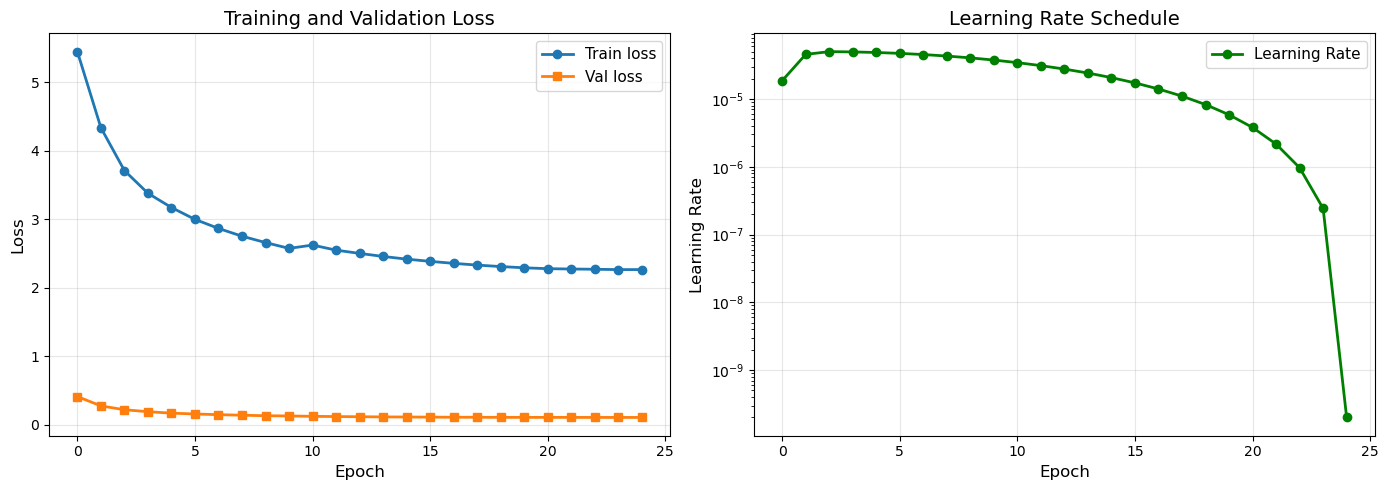

In [30]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'o-', label='Train loss', linewidth=2)
plt.plot(val_losses, 's-', label='Val loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(lrs, 'o-', label='Learning Rate', color='green', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('Learning Rate Schedule', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()